### 求解定态散射问题：

$$
  \bigg[-\frac{\hbar^2}{2m}\partial_x^2 +V(x) \bigg] \Psi_x = E \Psi_x
$$

#### a. 离散化: 

$$
\frac{\hbar^2}{2ma^2} \bigg[  -\Psi_{n-1} + (2-E+V_n)\Psi_n - \Psi_{n+1} \bigg] =0 
$$

#### b. 边界条件：


以k>0为例，即从系统的左边入射平面波，假设系统的格点总数为N个。


左边的lead中波函数的表达式：
$$
  \Psi^L = \frac{1}{\sqrt{V}} \bigg(e^{ikx} + r e^{-ikx} \bigg)
$$

离散化后，最左边的两个格点的波函数：
$$
\begin{cases}
\Psi_0 = \frac{1}{\sqrt{V}} (1+r)
\\
\Psi_1 = \frac{1}{\sqrt{V}} (e^{ika} + re^{-ika})
\end{cases}
$$

由此得到左边的边界条件：
$$
\Psi_0 - e^{ika}\ \Psi_1 = \frac{1}{\sqrt{V}} (1-e^{2ika})
$$

右边边的lead中波函数的表达式：
$$
  \Psi^R = \frac{1}{\sqrt{V}} t e^{ikx} 
$$

离散化后，最右边的两个格点的波函数：
$$
\begin{cases}
\Psi_{N-1} = \frac{t}{\sqrt{V}} e^{ika(N-1)}
\\
\Psi_{N-2} = \frac{t}{\sqrt{V}} e^{ika(N-2)}
\end{cases}
$$

由此得到右边的边界条件：
$$
\Psi_{N-1} - e^{ika}\ \Psi_{N-2} = 0
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from tqdm import tqdm

In [2]:
class onebody_wf:
   
    def __init__(self, momentum):
        self.momentum     = momentum
        self.energy       = 2*(1-np.cos(self.momentum)) #色散关系
        self.speed        = 2*np.sin(abs(momentum))
        #total num_cell
        self.total_num_cell = 100

    def init_operator(self):       
        #方势垒
        def potential_func(num_total):
            V0 = 0.1
            L  = 20
            pos_start     = int(num_total/2-L/2) 
            potential_vec = np.zeros(num_total)
            potential_vec[ pos_start:(pos_start+L) ] = V0
            return potential_vec
        # Central scattering region.
        diag_vec    = 2*np.ones(self.total_num_cell, dtype=complex) + potential_func(self.total_num_cell)
        #hopping
        offdiag_vec = - np.ones(self.total_num_cell - 1)
        #---------------------------------------
        #生成初始矩阵
        self.H0     = scipy.sparse.diags([diag_vec, offdiag_vec, offdiag_vec], [0, 1, -1])
    
    def scatteringState(self):   
        #构建定态散射方程
        matrix_eq = self.H0 - self.energy * sp.eye(self.total_num_cell)
        matrix_eq = sp.csr_matrix(matrix_eq)
        #定态散射边界条件
        #left
        matrix_eq[0,0]   = 1
        matrix_eq[0,1]   = -np.exp(1j*abs(self.momentum))
        #right
        matrix_eq[-1,-1] = 1
        matrix_eq[-1,-2] = -np.exp(1j*abs(self.momentum))
        #入射态对应的边界条件
        right_vec        = np.zeros(self.total_num_cell, dtype=complex)
        if self.momentum>0:            
            right_vec[0] = 1/np.sqrt(self.speed)*(1-np.exp( 2j*self.momentum)) 
        else:
            right_vec[-1]= 1/np.sqrt(self.speed)*(1-np.exp(-2j*self.momentum)) 
        #求解线性方程组，得到散射初态
        self.psi_init     = spsolve(matrix_eq, right_vec)  

## 波函数空间分布

In [3]:
#入射态的态指标
wf_withMomentum = onebody_wf(0.4)
#初始化H0
wf_withMomentum.init_operator()
#初态单体波函数
wf_withMomentum.scatteringState()

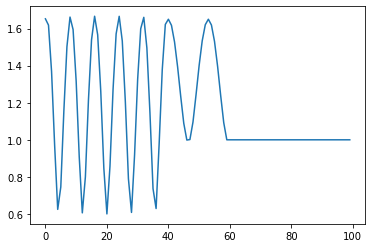

In [4]:
plt.plot( np.abs(wf_withMomentum.psi_init) )

## 与解析解对比

In [5]:
momentum_vec              = np.linspace(0, 0.5, 101)[1:]
transmission_vec          = np.zeros(momentum_vec.size)
transmission_analytic_vec = np.zeros(momentum_vec.size)

In [6]:
#解析解
#曾谨言，量子力学教程，page39
def transmission_ofSquare(k):
    V0     = 0.1
    L      = 20
    energy = 2*(1 - np.cos(k))
    kappa  = np.sqrt(V0-energy + 0j)
    transmission = 4*(k*kappa)**2/( (k**2-kappa**2)**2*np.sinh(kappa*L)**2 + 4*(k*kappa)**2*np.cosh(kappa*L)**2 )
    return abs(transmission)

In [7]:
for n_k in range(momentum_vec.size):
    #入射态的态指标
    k      = momentum_vec[n_k]
    #实例化
    wf_withMomentum = onebody_wf(k)
    #初始化H0
    wf_withMomentum.init_operator()
    #初态单体波函数
    wf_withMomentum.scatteringState()    
    #计算投射系数
    transmission_vec[n_k] = np.abs(wf_withMomentum.psi_init[-1])**2 * wf_withMomentum.speed
    #解析解
    transmission_analytic_vec[n_k] = transmission_ofSquare(k)

Text(0, 0.5, 'T')

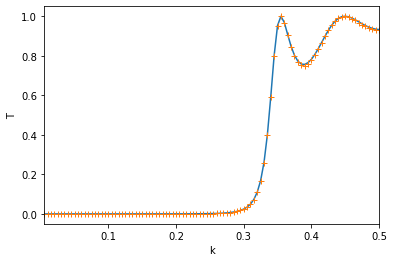

In [8]:
plt.plot(momentum_vec, transmission_analytic_vec)
plt.plot(momentum_vec, transmission_vec,'+')
plt.xlim([momentum_vec[0],momentum_vec[-1]])
plt.xlabel('k')
plt.ylabel('T')